# EDA on SuperStore Sales Dataset

### We have chosen the Super Store data from Kaggle to analyze trends and draw meaningful insights from them. 

# Objective: 
## 1. To parse the data from text file and store it in a normalized database. 
## 2. Extract and analyze the data from the normalized database to explore the following questions:

### Q: Which regions are generating the most revenue?
### Q: Which segement of customers make the most number of orders?
### Q: Which shipment mode is the most popular?
### Q: Which Countries generate the most revenue?
### Q: Which Product Categories have the highest average shipping cost?
### Q: Which are the most and the least profit generating product categories?
### Q: Which are the most profitable Markets?
### Q: Who are the top 10 profit generating customers?
### Q: Is the revenue increasing each year?

# Database Schema


![Alt text](../../../../Desktop/Screenshot%202022-12-15%20at%204.31.49%20PM.png)

Data Source - https://www.kaggle.com/datasets/aditisaxena20/superstore-sales-dataset

### First, we import the required libraries.

In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact_manual

### Now, we define the functions required to manipulate the databse. 

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


# Creating Market table 

In [3]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:

    market_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue        
        market_list.append(line.split('\t')[8])
        
market_list = sorted(list(set(market_list)))
#print(country_list)

market_tuples = []
for tupl in enumerate(market_list, 1):
    market_tuples.append(tupl)

#print(market_tuples)

create_table_sql = """CREATE TABLE IF NOT EXISTS [Market] (
[MarketID] INTEGER NOT NULL PRIMARY KEY, 
[Market] TEXT NOT NULL
                        );
                        """
conn_norm = create_connection('normalized.db',True)
create_table(conn_norm, create_table_sql,drop_table_name='Market')

def insert_market(conn, values):
    sql = ''' INSERT INTO Market(MarketID, Market)
            VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_market(conn_norm, market_tuples)


In [4]:
conn = create_connection('normalized.db')
sql_statement = 'select * from Market'
Markets = execute_sql_statement(sql_statement, conn)

market_dict = {}
for tupl in Markets:
    market_dict[tupl[1]] = tupl[0]

# Creating Region table 

In [5]:

with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:
    region_list = []
    headerflag = True
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue
        region_list.append(line.split('\t')[9])
region_list = sorted(list(set(region_list)))

#print(region_list)


region_tuples = []
for tupl in enumerate(region_list, 1):
    region_tuples.append(tupl)

#print(region_tuples)

create_table_sql = """CREATE TABLE IF NOT EXISTS [Region] (
[RegionID] INTEGER NOT NULL PRIMARY KEY, 
[Region] TEXT NOT NULL
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='Region')

def insert_region(conn, values):
    sql = ''' INSERT INTO Region(RegionID, Region)
            VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid  

with conn_norm:
    insert_region(conn_norm, region_tuples)

In [6]:
conn = create_connection('normalized.db')
sql_statement = 'select * from Region'
Regions = execute_sql_statement(sql_statement, conn)

region_dict = {}
for tupl in Regions:
    region_dict[tupl[1]] = tupl[0]

#print(region_dict)

# Creating Country table 

In [7]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:
    # def regionID(Region):
    #     return region_dict[Region]
    
    country_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue        
        country_list.append((line.split('\t')[7],region_dict[line.split('\t')[9]],market_dict[line.split('\t')[8]]))
        
country_list = sorted(list(set(country_list)), key = lambda tupl: tupl[0])
#print(country_list)


create_table_sql = """CREATE TABLE IF NOT EXISTS [Country] (
[CountryID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT, 
[Country] TEXT NOT NULL,
[RegionID] INTEGER NOT NULL,
[MarketID] INTEGER NOT NULL,
FOREIGN KEY(RegionID) REFERENCES Region(RegionID),
FOREIGN KEY(MarketID) REFERENCES Market(MarketID)
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='Country')

def insert_country(conn, values):
    sql = ''' INSERT INTO Country(Country, RegionID, MarketID)
            VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_country(conn_norm, country_list)


In [8]:
conn = create_connection('normalized.db')
sql_statement = 'select * from Country'
Countries = execute_sql_statement(sql_statement, conn)
country_dict = {}
for tupl in Countries:
    country_dict[tupl[1]] = tupl[0]

#print(country_dict)

# Creating ProductCategory table 

In [9]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:

    prodcat_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue        
        prodcat_list.append(line.split('\t')[11])
        
prodcat_list = sorted(list(set(prodcat_list)))
#print(country_list)

prodcat_tuples = []
for tupl in enumerate(prodcat_list, 1):
    prodcat_tuples.append(tupl)

#print(prodcat_tuples)

create_table_sql = """CREATE TABLE IF NOT EXISTS [ProductCategory] (
[ProductCategoryID] INTEGER NOT NULL PRIMARY KEY, 
[ProductCategory] TEXT NOT NULL
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='ProductCategory')

def insert_prodcat(conn, values):
    sql = ''' INSERT INTO ProductCategory(ProductCategoryID, ProductCategory)
            VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_prodcat(conn_norm, prodcat_tuples)


In [10]:
conn = create_connection('normalized.db')
sql_statement = 'select * from ProductCategory'
ProductCategories = execute_sql_statement(sql_statement, conn)
prodcat_dict = {}
for tupl in ProductCategories:
    prodcat_dict[tupl[1]] = tupl[0]

#print(prodcat_dict)

# Creating ProductSubCategory table 

In [11]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:
    # def regionID(Region):
    #     return region_dict[Region]
    
    subcat_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue        
        subcat_list.append((line.split('\t')[12],prodcat_dict[line.split('\t')[11]]))
        
subcat_list = sorted(list(set(subcat_list)), key = lambda tupl: tupl[0])
#print(country_list)


create_table_sql = """CREATE TABLE IF NOT EXISTS [ProductSubCategory] (
[ProductSubCategoryID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT, 
[ProductSubCategory] TEXT NOT NULL,
[ProductCategoryID] INTEGER NOT NULL,
FOREIGN KEY(ProductCategoryID) REFERENCES ProductCategory(ProductCategoryID)
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='ProductSubCategory')

def insert_subcat(conn, values):
    sql = ''' INSERT INTO ProductSubCategory(ProductSubCategory, ProductCategoryID)
            VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_subcat(conn_norm, subcat_list)


In [12]:
conn = create_connection('normalized.db')
sql_statement = 'select * from ProductSubCategory'
ProductSubCategories = execute_sql_statement(sql_statement, conn)
subcat_dict = {}
for tupl in ProductSubCategories:
    subcat_dict[tupl[1]] = tupl[0]

#print(subcat_dict)

# Creating Product table 

In [13]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:
    # def regionID(Region):
    #     return region_dict[Region]
    
    prod_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue 
             
        prod_list.append((line.split('\t')[13],prodcat_dict[line.split('\t')[11]],subcat_dict[line.split('\t')[12]]))
        
prod_list = sorted(list(set(prod_list)), key = lambda tupl: tupl[0])
#print(prod_list)


create_table_sql = """CREATE TABLE IF NOT EXISTS [Product] (
[ProductID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT, 
[ProductName] TEXT NOT NULL,
[ProductCategoryID] INTEGER NOT NULL,
[ProductSubCategoryID] INTEGER NOT NULL,
FOREIGN KEY(ProductCategoryID) REFERENCES ProductCategory(ProductCategoryID),
FOREIGN KEY(ProductSubCategoryID) REFERENCES ProductSubCategory(ProductSubCategoryID)
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='Product')

def insert_product(conn, values):
    sql = ''' INSERT INTO Product(ProductName,ProductCategoryID,ProductSubCategoryID )
            VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_product(conn_norm, prod_list)


In [14]:
conn = create_connection('normalized.db')
sql_statement = 'select * from Product'
Products = execute_sql_statement(sql_statement, conn)
product_dict = {}
for tupl in Products:
    product_dict[tupl[1]] = tupl[0]

#print(len(product_dict))

# Creating Customer table 

In [15]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:
    # def regionID(Region):
    #     return region_dict[Region]
    
    customer_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue 
             
        customer_list.append((line.split('\t')[4].split()[0],line.split('\t')[4].split()[-1]))
        
customer_list = sorted(list(set(customer_list)), key = lambda tupl: (tupl[0],tupl[1]))
#print(prod_list)


create_table_sql = """CREATE TABLE IF NOT EXISTS [Customer] (
[CustomerID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
[FirstName] TEXT NOT NULL,
[LastName] TEXT NOT NULL
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='Customer')

def insert_customer(conn, values):
    sql = ''' INSERT INTO Customer(FirstName,LastName)
            VALUES(?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_customer(conn_norm, customer_list)


In [16]:
conn = create_connection('normalized.db')
sql_statement = 'select * from Customer'
Customers = execute_sql_statement(sql_statement, conn)
customer_dict = {}
for tupl in Customers:
    customer_dict[' '.join([tupl[1],tupl[2]])] = tupl[0]

# Creating CustomerDetails table

In [17]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:
    # def regionID(Region):
    #     return region_dict[Region]
    
    cusdetail_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue 
             
        cusdetail_list.append((line.split('\t')[4].split()[0],line.split('\t')[4].split()[-1],customer_dict[' '.join([line.split('\t')[4].split()[0],line.split('\t')[4].split()[-1]])],line.split('\t')[5],country_dict[line.split('\t')[7]]))
        
cusdetail_list = sorted(list(set(cusdetail_list)), key = lambda tupl: (tupl[0],tupl[1]))
#print(prod_list)


create_table_sql = """CREATE TABLE IF NOT EXISTS [CustomerDetails] (
[FirstName] TEXT NOT NULL,
[LastName] TEXT NOT NULL,
[CustomerID] INTEGER NOT NULL,
[Segment] TEXT NOT NULL,
[CountryID] INTEGER NOT NULL,
FOREIGN KEY(CountryID) REFERENCES Country(CountryID),
FOREIGN KEY(CustomerID) REFERENCES Customer(CustomerID)
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='CustomerDetails')

def insert_custdetails(conn, values):
    sql = ''' INSERT INTO CustomerDetails(FirstName,LastName,CustomerID, Segment, CountryID)
            VALUES(?,?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_custdetails(conn_norm, cusdetail_list)


# Creating Orders table

In [18]:
with open('SuperStoreOrders.tsv', 'r',encoding='utf-8') as fhandle:
    # def regionID(Region):
    #     return region_dict[Region]
    
    order_list = []
    headerflag = True
    
    for line in fhandle:
        if headerflag:
            headerflag = False
            continue 
             
        order_list.append((
        line.split('\t')[1],
        line.split('\t')[2],
        line.split('\t')[3],
        customer_dict[' '.join([line.split('\t')[4].split()[0],line.split('\t')[4].split()[-1]])],
        country_dict[line.split('\t')[7]],
        product_dict[line.split('\t')[13]],
        line.split('\t')[14],
        line.split('\t')[15],
        line.split('\t')[16],
        line.split('\t')[17],
        line.split('\t')[18],
        line.split('\t')[19],
        line.split('\t')[20]
        ))
        
order_list = sorted(list(set(order_list)), key = lambda tupl: tupl[0])
#print(prod_list)


create_table_sql = """CREATE TABLE IF NOT EXISTS [Orders] (
[OrderID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
[OrderDate] TEXT NOT NULL,
[ShipDate] TEXTNOT NULL,
[ShipMode] TEXT NOT NULL,
[CustomerID] INTEGER NOT NULL,
[CountryID] INTEGER NOT NULL,
[ProductID] INTEGER NOT NULL,
[Sales] INTEGER NOT NULL,
[Quantity] INTEGER NOT NULL,
[Discount] REAL NOT NULL,
[Profit] REAL NOT NULL,
[ShippingCost] REAL NOT NULL,
[OrderPriority] TEXT NOT NULL,
[Year] TEXT NOT NULL,
FOREIGN KEY(CustomerID) REFERENCES Customer(CustomerID),
FOREIGN KEY(CountryID) REFERENCES Country(CountryID),
FOREIGN KEY(ProductID) REFERENCES Product(ProductID)
                        );
                        """
conn_norm = create_connection('normalized.db')
create_table(conn_norm, create_table_sql,drop_table_name='Orders')

def insert_order(conn, values):
    sql = ''' INSERT INTO Orders (OrderDate,ShipDate,ShipMode,CustomerID,CountryID,ProductID,Sales,Quantity,Discount,Profit,ShippingCost,OrderPriority,Year) 
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid 

with conn_norm:
    insert_order(conn_norm, order_list)


# Exploratory Data Analysis

# Q: Which regions are generating the most revenue?

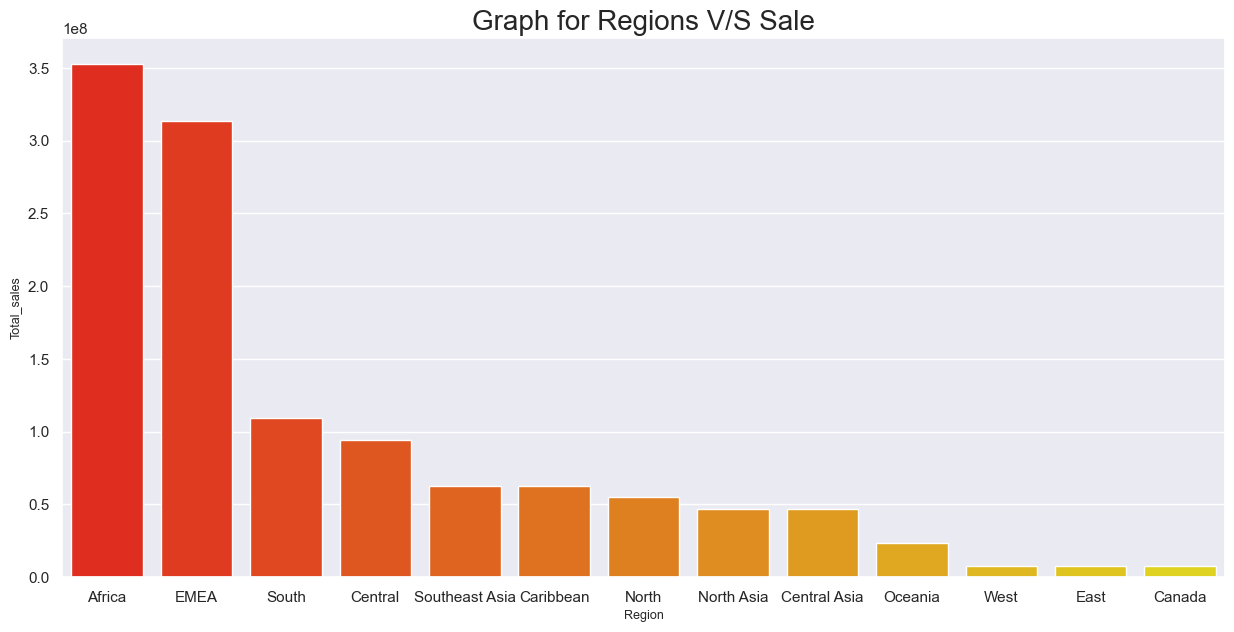

In [19]:
df= pd.read_sql_query('''SELECT Region.Region, 
sum(Orders.Sales) as Total_sales
from Orders join Country 
on  Orders.CountryID=Orders.CountryID 
join Region 
on Country.RegionID = Region.RegionID
group by Region 
order by Total_sales desc''', conn)
plt.rcParams['figure.figsize'] = (15, 7)
ax = sns.barplot(x =df['Region'], y = df['Total_sales'], palette = 'autumn')
ax.set_xlabel(xlabel = 'Region', fontsize = 9)
ax.set_ylabel(ylabel = 'Total_sales', fontsize = 9)
ax.set_title(label = 'Graph for Regions V/S Sale', fontsize = 20)
plt.show()

### Insight: Africa and EMEA have significantly higher revenue compared to other regions. 

# Q: Which segement of customers make the most number of orders?

<BarContainer object of 3 artists>

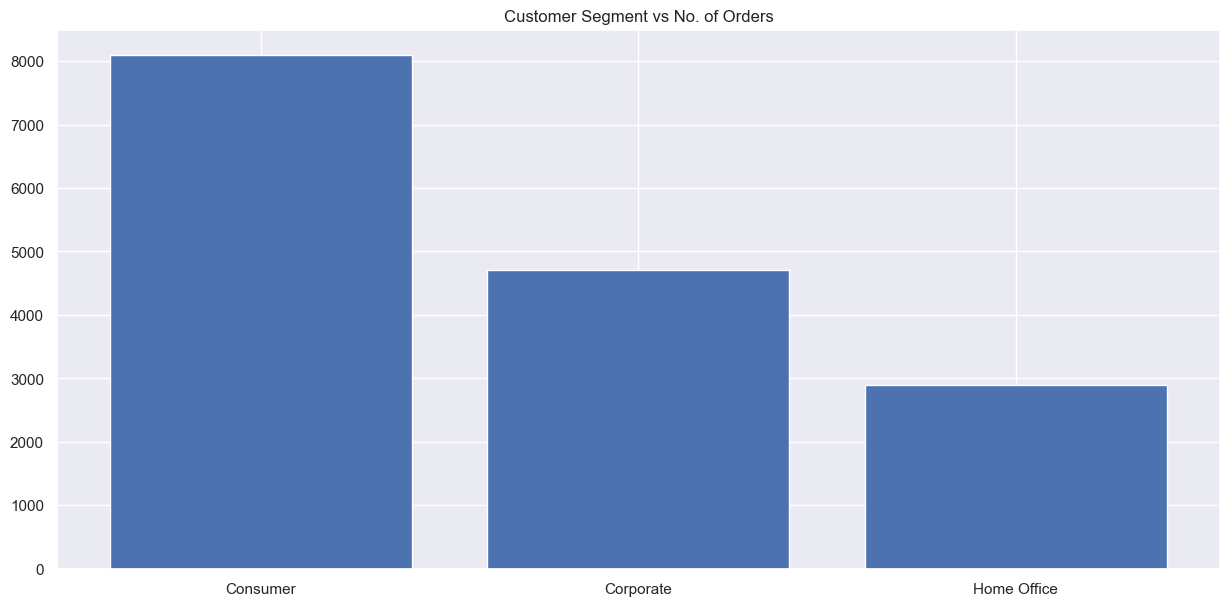

In [20]:
conn = create_connection('normalized.db')
df= pd.read_sql_query('''SELECT Segment, count(Segment) as count from CustomerDetails group by Segment;''', conn)
plt.title("Customer Segment vs No. of Orders")
plt.bar(x = df['Segment'], height = df['count'])

### Insight: Consumer segment makes the most number of orders. 

# Q: Which shipment mode is the most popular?

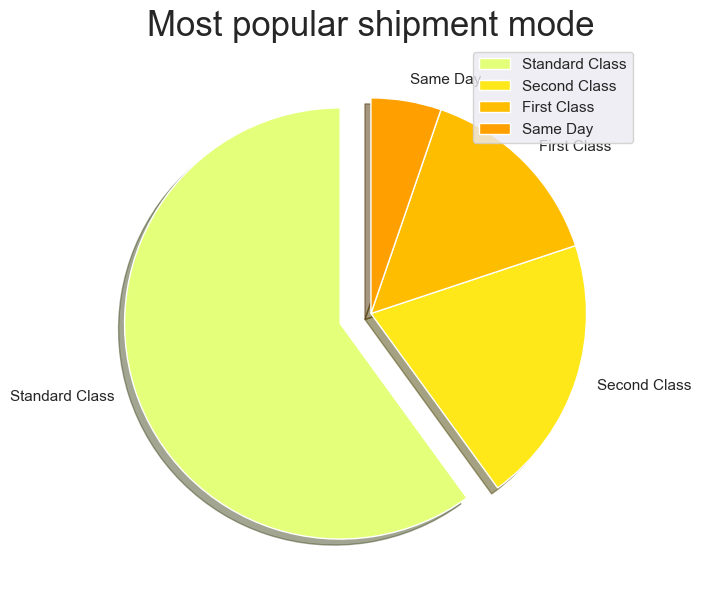

In [21]:
df= pd.read_sql_query('''select ShipMode, count(*) as No_of_Orders
from orders 
group by ShipMode
order by No_of_Orders desc''', conn)
labels = ['Standard Class', 'Second Class', 'First Class','Same Day'] 
size = df["No_of_Orders"]
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
explode = [0.15, 0, 0, 0]

plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Most popular shipment mode', fontsize = 25)
plt.legend()
plt.show()

### Insight: Standard class is the most preferred and Same Day delievery is least preferred. 

# Q: Which Countries generate the most revenue?

In [22]:
df= pd.read_sql_query('''SELECT Country.Country, 
sum(Orders.Sales) as Total_sales
from Orders join Country 
on  Orders.CountryID=Country.CountryID 
group by Country 
order by Total_sales desc''', conn)

@interact
def skill(Sales =["Total_sales"], score =-11355632.0):
    return df[df[Sales] > score][['Country', Sales]].sort_values(by = Sales,ascending = False).head(20).style.background_gradient(cmap = 'Blues')

interactive(children=(Dropdown(description='Sales', options=('Total_sales',), value='Total_sales'), FloatSlide…

### Insight: United States generates significantly higher revenue compared to other countries. 

# Q: Which Product Categories have the highest average shipping cost?

In [23]:
df= pd.read_sql_query('''select sc.ProductSubCategory, round(avg(o.ShippingCost),2) as Average_Shipping_Cost
from orders o join product p 
on o.ProductID = p.ProductID
join ProductSubCategory sc 
on sc.ProductSubCategoryID = p.ProductSubCategoryID
group by sc.ProductSubCategory
order by Average_Shipping_Cost  desc''', conn)
df.sort_values('Average_Shipping_Cost', ascending = False)[['ProductSubCategory', 'Average_Shipping_Cost']].head(15).style.background_gradient(cmap = 'Wistia')

,ProductSubCategory,Average_Shipping_Cost
0,Tables,92.750000
1,Copiers,71.750000
2,Bookcases,64.490000
3,Appliances,62.140000
4,Phones,55.080000
5,Machines,53.250000
6,Chairs,47.820000
7,Accessories,27.160000
8,Storage,23.870000
9,Furnishings,12.910000


### Insight: We were expecting the furniture items to have the highest shipping cost. Although theres no clear trend but Tables, Bookcases and Chairs feature in the top 50 percentile. 

# Q:Which are the most and the least profit generating product categories?

   ProductSubCategory  Average_Profit
0             Copiers      116.314687
1          Appliances       81.264402
2           Bookcases       67.160688
3              Phones       64.556749
4         Accessories       42.154896
5              Chairs       41.343564
6            Machines       39.614989
7             Storage       21.472902
8               Paper       16.641367
9         Furnishings       14.864529
10          Envelopes       12.086086
11                Art       11.889363
12            Binders       11.785414
13           Supplies        9.372329
14             Labels        6.223477
15          Fasteners        4.731769
16             Tables      -74.429023


<BarContainer object of 17 artists>

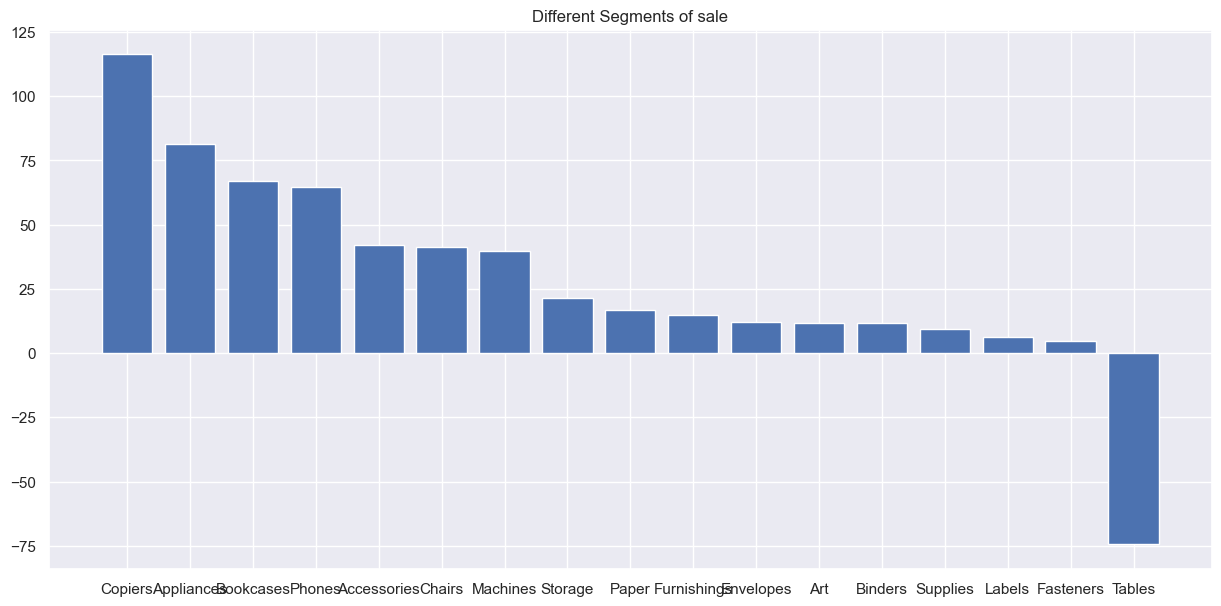

In [24]:
df= pd.read_sql_query('''select sc.ProductSubCategory, avg(o.Profit) as Average_Profit
from orders o join product p 
on o.ProductID = p.ProductID
join ProductSubCategory sc 
on sc.ProductSubCategoryID = p.ProductSubCategoryID
group by sc.ProductSubCategory
order by Average_Profit  desc''', conn)
print(df)
plt.title("Different Segments of sale")
plt.bar(x = df['ProductSubCategory'], height = df['Average_Profit'])

### Insight: One of the product subcategories(Tables) is actually generating loss. We can explore the reasons and decide the future course for this product subcategory

# Q: Which are the most profitable Markets?

In [25]:
df= pd.read_sql_query('''select m.Market, round(sum(o.Profit),2) as Total_Profit
from orders o join Country c 
on o.CountryID = c.CountryID
join Market m 
on c.MarketID = m.MarketID
group by m.Market
order by Total_Profit  desc''', conn)
df.sort_values('Total_Profit', ascending = False)[['Market', 'Total_Profit']].head(15).style.background_gradient(cmap = 'Reds')


,Market,Total_Profit
0,APAC,437594.590000
1,EU,375729.180000
2,US,286397.020000
3,LATAM,221665.920000
4,Africa,88871.630000
5,EMEA,40981.520000
6,Canada,17817.390000


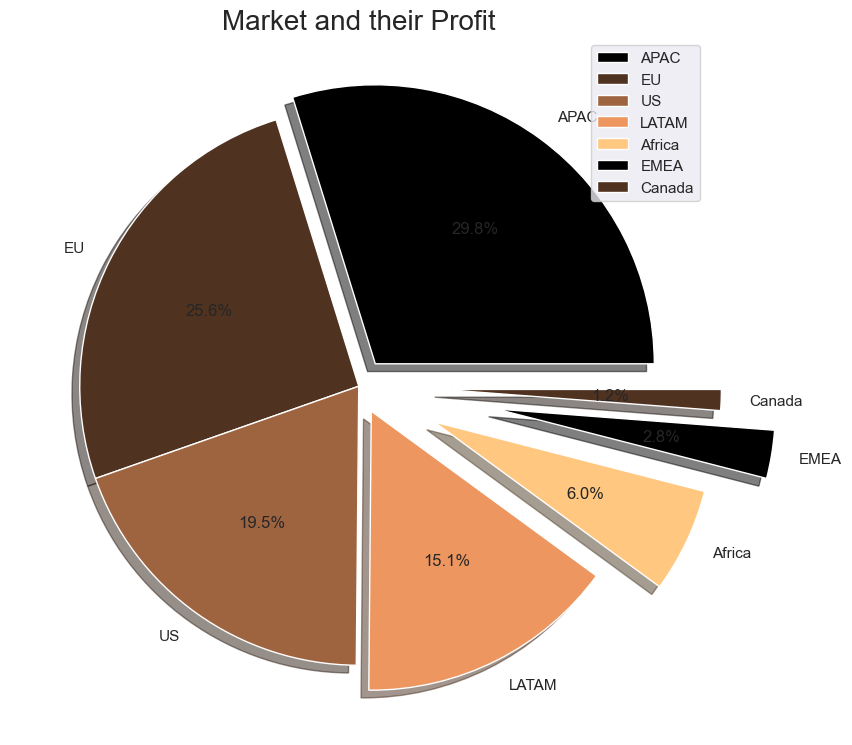

In [26]:
labels = ['APAC', 'EU', 'US', 'LATAM', 'Africa','EMEA','Canada']
sizes = df['Total_Profit']
colors = plt.cm.copper(np.linspace(0, 1, 5))
explode = [0.1, 0, 0, 0.1, 0.3,0.5,0.3]

plt.rcParams['figure.figsize'] = (9, 11)
plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, autopct='%1.1f%%')
plt.title('Market and their Profit', fontsize = 20)
plt.legend()
plt.show()

### Insight: The canadian market is unexplored and presents an opportunity. 

# Q: Who are the top 10 profit generating customers?

([<matplotlib.patches.Wedge at 0x7fdcfa79cb20>,
 [Text(1.024650006644242, 0.40011543819747136, 'Tamara Chand'),
  Text(0.4916811610252721, 0.983996766200398, 'Raymond Buch'),
  Text(-0.27392143428401994, 1.0653483223058013, 'Sanjit Chand'),
  Text(-0.8879272984073943, 0.6492958591758817, 'Hunter Lopez'),
  Text(-1.099728865005824, -0.024421782756437242, 'Bill Eplett'),
  Text(-0.8829897105921316, -0.6559947949400392, 'Harry Marie'),
  Text(-0.3821594574697618, -1.0314815311320011, 'Susan Pistek'),
  Text(0.2193572193162988, -1.0779064942441998, 'Mike Gockenbach'),
  Text(0.7525811608840004, -0.8022603045660994, 'Adrian Barton'),
  Text(1.0598719343275798, -0.29440020860168303, 'Tom Ashbrook')],
 [Text(0.5589000036241321, 0.21824478447134799, '11.9%'),
  Text(0.26818972419560294, 0.5367255088365807, '11.5%'),
  Text(-0.1494116914276472, 0.5810990848940734, '11.2%'),
  Text(-0.4843239809494877, 0.35416137773229905, '10.7%'),
  Text(-0.5998521081849948, -0.01332097241260213, '10.1%'),
  T

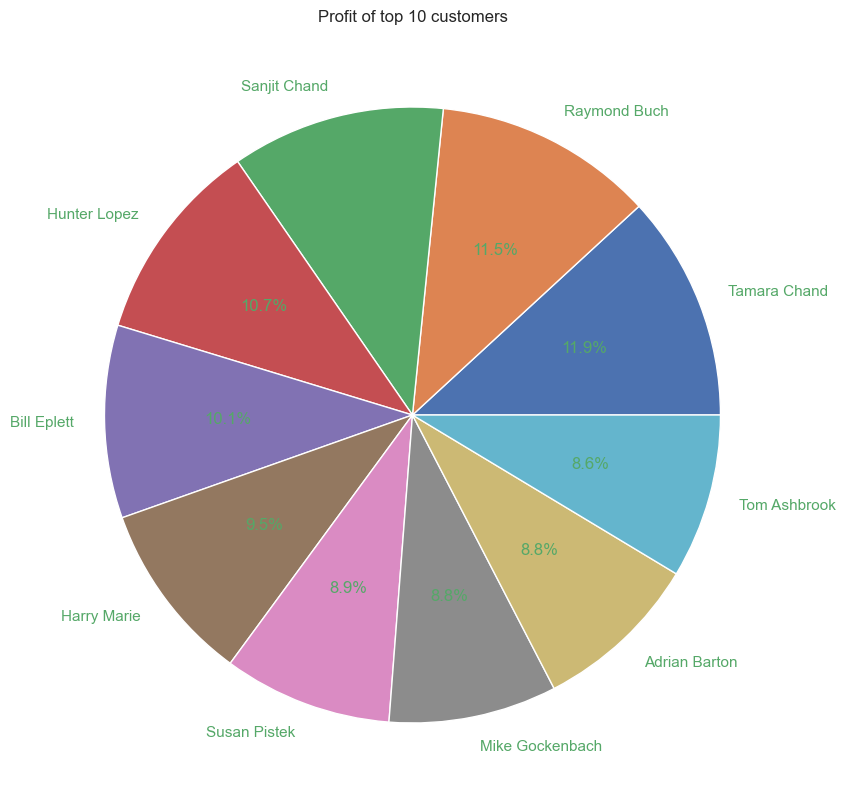

In [27]:
df= pd.read_sql_query('''SELECT Customer.FirstName||' '||Customer.LastName as Name, 
sum(Orders.Profit) as Total_profit 
from Orders join Customer 
on  Customer.CustomerID=Orders.CustomerID 
group by Name 
order by Total_profit desc
limit 10''', conn)

top_ten = df
plt.rcParams['figure.figsize'] = (20, 10)
plt.title('Profit of top 10 customers')
plt.pie(top_ten['Total_profit'], labels= top_ten['Name'], textprops={'color':'g'}, autopct='%1.1f%%')


### Insight: The superstore can reward their most loyal customers. 

# Q: Is the revenue increasing each year?

     Year      Sales
3  2011\n  1378859.0
2  2012\n  1682274.0
1  2013\n  2108044.0
0  2014\n  2669728.0


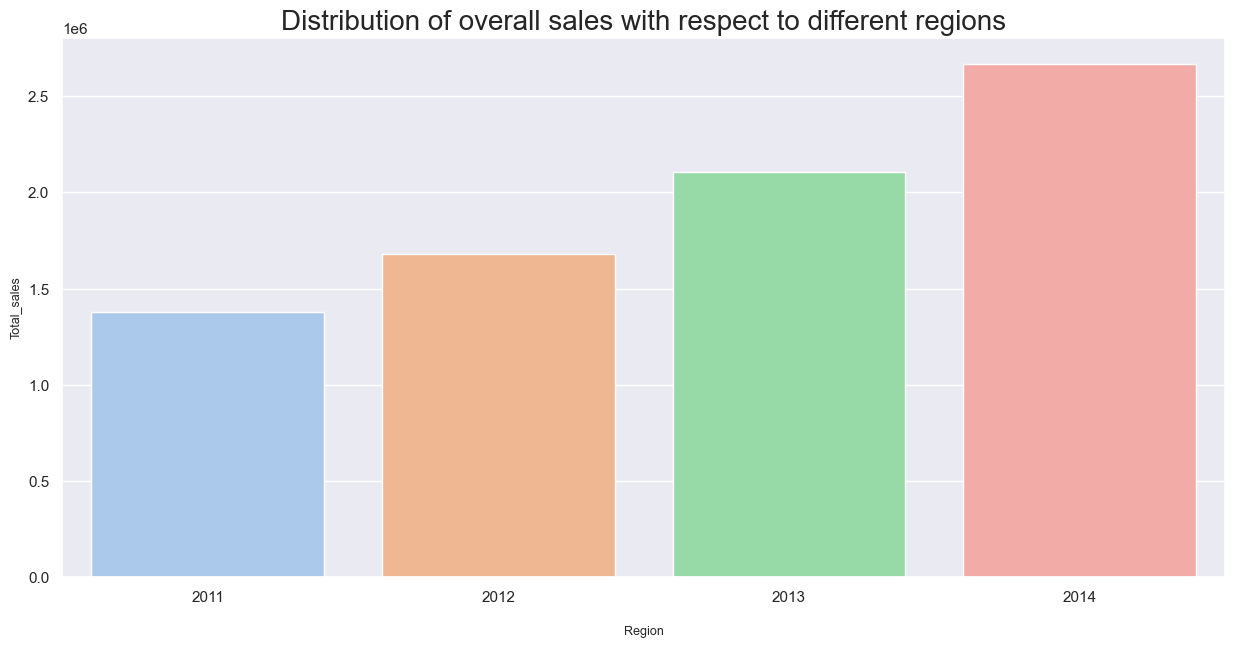

In [28]:
df= pd.read_sql_query('''select Year, sum(Sales) as Sales
from orders 
group by Year
order by Sales desc
limit 4''', conn)
plt.rcParams['figure.figsize'] = (15, 7)
df.sort_values(by=['Sales'],ascending=True,inplace=True)
print(df)
ax = sns.barplot(x =df['Year'], y = df['Sales'], palette = 'pastel')
ax.set_xlabel(xlabel = 'Region', fontsize = 9)
ax.set_ylabel(ylabel = 'Total_sales', fontsize = 9)
ax.set_title(label = 'Distribution of overall sales with respect to different regions', fontsize = 20)
plt.show()


### Insight: Indeed the revenue is increasing each year. 






# Conclusion: EDA on the given dataset of Superstore Sale was conducted sucessfully and useful insights were drawn.